In [13]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

|# 历史天气部分

## 将经纬度找到指定的county

In [14]:
historical_weather = pd.read_csv("../data/historical_weather.csv",parse_dates=['datetime'])
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637


In [15]:
historical_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710800 entries, 0 to 1710799
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   datetime                datetime64[ns]
 1   temperature             float64       
 2   dewpoint                float64       
 3   rain                    float64       
 4   snowfall                float64       
 5   surface_pressure        float64       
 6   cloudcover_total        int64         
 7   cloudcover_low          int64         
 8   cloudcover_mid          int64         
 9   cloudcover_high         int64         
 10  windspeed_10m           float64       
 11  winddirection_10m       int64         
 12  shortwave_radiation     float64       
 13  direct_solar_radiation  float64       
 14  diffuse_radiation       float64       
 15  latitude                float64       
 16  longitude               float64       
 17  data_block_id           int64         
dtypes:

In [16]:
historical_weather['datetime_merge'] = historical_weather['datetime']+ np.timedelta64(13,'h')
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,datetime_merge
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1,2021-09-01 13:00:00
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1,2021-09-01 13:00:00
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1,2021-09-01 13:00:00
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1,2021-09-01 13:00:00
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1,2021-09-01 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637,2023-05-30 23:00:00
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637,2023-05-30 23:00:00
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637,2023-05-30 23:00:00
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637,2023-05-30 23:00:00


In [17]:
historical_weather['year'] = historical_weather['datetime_merge'].apply(lambda x: x.year)
historical_weather['month'] = historical_weather['datetime_merge'].apply(lambda x: x.month)
historical_weather['day'] = historical_weather['datetime_merge'].apply(lambda x: x.day)
historical_weather['hour'] = historical_weather['datetime_merge'].apply(lambda x: x.hour)
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,datetime_merge,year,month,day,hour
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1,2021-09-01 13:00:00,2021,9,1,13
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1,2021-09-01 13:00:00,2021,9,1,13
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1,2021-09-01 13:00:00,2021,9,1,13
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1,2021-09-01 13:00:00,2021,9,1,13
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1,2021-09-01 13:00:00,2021,9,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637,2023-05-30 23:00:00,2023,5,30,23
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637,2023-05-30 23:00:00,2023,5,30,23
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637,2023-05-30 23:00:00,2023,5,30,23
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637,2023-05-30 23:00:00,2023,5,30,23


In [18]:
historical_weather['latitude'] = historical_weather['latitude'].astype(float).round(1)
historical_weather['longitude'] = historical_weather['longitude'].astype(float).round(1)
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,datetime_merge,year,month,day,hour
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1,2021-09-01 13:00:00,2021,9,1,13
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1,2021-09-01 13:00:00,2021,9,1,13
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1,2021-09-01 13:00:00,2021,9,1,13
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1,2021-09-01 13:00:00,2021,9,1,13
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1,2021-09-01 13:00:00,2021,9,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637,2023-05-30 23:00:00,2023,5,30,23
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637,2023-05-30 23:00:00,2023,5,30,23
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637,2023-05-30 23:00:00,2023,5,30,23
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637,2023-05-30 23:00:00,2023,5,30,23


In [19]:
weather_to_county = pd.read_csv("../data/weather_station_to_county_mapping.csv")
weather_to_county

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN
...,...,...,...,...
107,NaN,28.2,58.5,NaN
108,NaN,28.2,58.8,NaN
109,NaN,28.2,59.1,NaN
110,NaN,28.2,59.4,NaN


In [20]:
historical_weather.groupby(by=["longitude","latitude"])["data_block_id"].describe().unstack()


count                                                        \
latitude      57.6     57.9     58.2     58.5     58.8     59.1     59.4   
longitude                                                                  
21.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
22.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
22.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
23.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
23.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
24.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
24.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
25.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
25.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
26.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
26.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
27.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
27.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
28.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   

                          mean                                      \
latitude      59.7        57.6        57.9        58.2        58.5   
longitude                                                            
21.7       15275.0  319.270638  319.270638  319.270638  319.270638   
22.2       15275.0  319.270638  319.270638  319.270638  319.270638   
22.7       15275.0  319.270638  319.270638  319.270638  319.270638   
23.2       15275.0  319.270638  319.270638  319.270638  319.270638   
23.7       15275.0  319.270638  319.270638  319.270638  319.270638   
24.2       15275.0  319.270638  319.270638  319.270638  319.270638   
24.7       15275.0  319.270638  319.270638  319.270638  319.270638   
25.2       15275.0  319.270638  319.270638  319.270638  319.270638   
25.7       15275.0  319.270638  319.270638  319.270638  319.270638   
26.2       15275.0  319.270638  319.270638  319.270638  319.270638   
26.7       15275.0  319.270638  319.270638  319.270638  319.270638   
27.2       15275.0  319.270638  319.270638  319.270638  319.270638   
27.7       15275.0  319.270638  319.270638  319.270638  319.270638   
28.2       15275.0  319.270638  319.270638  319.270638  319.270638   

                                                                 std  \
latitude         58.8        59.1        59.4        59.7       57.6   
longitude                                                              
21.7       319.270638  319.270638  319.270638  319.270638  183.73582   
22.2       319.270638  319.270638  319.270638  319.270638  183.73582   
22.7       319.270638  319.270638  319.270638  319.270638  183.73582   
23.2       319.270638  319.270638  319.270638  319.270638  183.73582   
23.7       319.270638  319.270638  319.270638  319.270638  183.73582   
24.2       319.270638  319.270638  319.270638  319.270638  183.73582   
24.7       319.270638  319.270638  319.270638  319.270638  183.73582   
25.2       319.270638  319.270638  319.270638  319.270638  183.73582   
25.7       319.270638  319.270638  319.270638  319.270638  183.73582   
26.2       319.270638  319.270638  319.270638  319.270638  183.73582   
26.7       319.270638  319.270638  319.270638  319.270638  183.73582   
27.2       319.270638  319.270638  319.270638  319.270638  183.73582   
27.7       319.270638  319.270638  319.270638  319.270638  183.73582   
28.2       319.270638  319.270638  319.270638  319.270638  183.73582   

                                                                             \
latitude        57.9       58.2       58.5       58.8       59.1       59.4   
longitude                                                                     
21.7       183.73582  183.73582  183.73582  183.73582  183.73582  1

In [21]:
weather_to_county.groupby(by=["longitude","latitude"])["county"].describe().unstack().count()

       latitude
count  57.6        14
       57.9        14
       58.2        14
       58.5        14
       58.8        14
                   ..
max    58.5        11
       58.8         8
       59.1         9
       59.4         8
       59.7         0
Length: 64, dtype: int64

In [22]:
location = pd.read_csv("../data/county_lon_lats.csv").drop(columns = ["Unnamed: 0"])

# Convert to int to avoid float imprecision
for k in ['latitude', 'longitude'] :
    location[k] = (10*location[k]).astype(int)

location

,county,longitude,latitude
0,0,242,591
1,0,252,591
2,0,237,594
3,0,242,594
4,0,247,594
...,...,...,...
70,15,267,576
71,15,272,576
72,15,267,579
73,15,272,579


In [23]:
def process_weather_info(h, location=location) :

    # Drop duplicates
    h = h.drop_duplicates().reset_index(drop=True)

    # Convert to int to avoid float imprecision
    for k in ['latitude', 'longitude'] :
        h[k] = (10*h[k]).astype(int)

    # Add location
    h = pd.merge(h, location, how='left', on=['latitude', 'longitude'])

    # Fill NaN and force int
    h['county'] = h['county'].fillna(-1).astype(int)

    # Return
    return h

In [24]:
historical_weather = process_weather_info(historical_weather)
historical_weather
#成功将经纬度找到county

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,datetime_merge,year,month,day,hour,county
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,576,217,1,2021-09-01 13:00:00,2021,9,1,13,-1
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,576,222,1,2021-09-01 13:00:00,2021,9,1,13,-1
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,576,227,1,2021-09-01 13:00:00,2021,9,1,13,-1
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,576,232,1,2021-09-01 13:00:00,2021,9,1,13,10
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,576,237,1,2021-09-01 13:00:00,2021,9,1,13,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,597,262,637,2023-05-30 23:00:00,2023,5,30,23,5
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,597,267,637,2023-05-30 23:00:00,2023,5,30,23,5
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,597,272,637,2023-05-30 23:00:00,2023,5,30,23,-1
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,597,277,637,2023-05-30 23:00:00,2023,5,30,23,-1


保存成新的csv，成功后就不运行了

In [25]:
# historical_weather.to_csv('../data/historical_weather_New.csv')

In [26]:
historical_weather = historical_weather.drop_duplicates(['data_block_id','county'])

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
train = pd.read_csv("../data/train.csv",parse_dates=['datetime'])
train['county'] = train['county'].astype(int)
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
1048570,7,0,1,16.237,0,2022-08-02 20:00:00,335,1048570,25
1048571,7,0,1,46.429,1,2022-08-02 20:00:00,335,1048571,25
1048572,7,0,3,49.939,0,2022-08-02 20:00:00,335,1048572,27
1048573,7,0,3,118.012,1,2022-08-02 20:00:00,335,1048573,27


In [29]:
train['year'] = train['datetime'].apply(lambda x: x.year)
train['month'] = train['datetime'].apply(lambda x: x.month)
train['day'] = train['datetime'].apply(lambda x: x.day)
train['hour'] = train['datetime'].apply(lambda x: x.hour)
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,year,month,day,hour
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021,9,1,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021,9,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021,9,1,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021,9,1,0
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,7,0,1,16.237,0,2022-08-02 20:00:00,335,1048570,25,2022,8,2,20
1048571,7,0,1,46.429,1,2022-08-02 20:00:00,335,1048571,25,2022,8,2,20
1048572,7,0,3,49.939,0,2022-08-02 20:00:00,335,1048572,27,2022,8,2,20
1048573,7,0,3,118.012,1,2022-08-02 20:00:00,335,1048573,27,2022,8,2,20


In [30]:
train_new= train[['county', 'data_block_id', 'target','is_consumption','is_business','product_type','hour']]
train_new_is_consumption = train_new[train_new['is_consumption']==1]
train_new_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour
1,0,0,96.590,1,0,1,0
3,0,0,17.314,1,0,2,0
5,0,0,656.859,1,0,3,0
7,0,0,59.000,1,1,0,0
9,0,0,501.760,1,1,1,0
...,...,...,...,...,...,...,...
1048565,5,335,70.632,1,1,1,20
1048567,5,335,676.373,1,1,3,20
1048569,6,335,217.705,1,1,3,20
1048571,7,335,46.429,1,0,1,20


In [31]:
train_group_by = train.groupby('county')['target'].describe()
train_group_by

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
0,111386.0,825.153596,2025.957999,0.0,0.59400,49.5170,486.45450,13896.422
1,48354.0,34.586789,54.362684,0.0,0.14200,11.7590,51.80975,435.548
2,57178.0,165.276639,454.781636,0.0,0.11600,17.3470,67.86225,3036.604
3,64472.0,149.659002,284.397083,0.0,0.01500,30.3975,106.64050,1702.566
4,74736.0,123.313065,202.551501,0.0,0.08700,18.3770,154.63000,1248.623
5,79102.0,221.358705,361.202753,0.0,0.90300,51.4800,199.71750,1894.246
6,16118.0,62.189757,67.177602,0.0,0.00500,40.9170,120.59825,269.434
7,91095.0,174.789969,277.250895,0.0,0.20400,41.6850,233.49300,1682.319
8,48348.0,64.331945,99.989932,0.0,0.11400,17.2795,81.71350,627.347


In [32]:
merged_is_consumption = pd.merge(train_new_is_consumption, historical_weather,how='left', on=['data_block_id', 'county','hour'])

In [33]:
merged_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,datetime_merge,year,month,day
0,0,0,96.590,1,0,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,0,0,17.314,1,0,2,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,0,0,656.859,1,0,3,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,0,0,59.000,1,1,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,0,0,501.760,1,1,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524282,5,335,70.632,1,1,1,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
524283,5,335,676.373,1,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
524284,6,335,217.705,1,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
524285,7,335,46.429,1,0,1,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


In [34]:
train_new_no_consumption = train_new[train_new['is_consumption']==0]

In [35]:
merged_no_consumption  = pd.merge(train_new_no_consumption, historical_weather,how='left', on=['data_block_id', 'county','hour'])

In [36]:
merged_no_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,datetime_merge,year,month,day
0,0,0,0.713,0,0,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,0,0,0.000,0,0,2,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,0,0,2.904,0,0,3,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,0,0,0.000,0,1,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,0,0,0.000,0,1,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524283,5,335,24.534,0,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
524284,6,335,6.001,0,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
524285,7,335,16.237,0,0,1,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
524286,7,335,49.939,0,0,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


In [37]:
merged_is_consumption = merged_is_consumption .dropna()
merged_no_consumption = merged_no_consumption .dropna()
merged_no_consumption
merged_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,datetime_merge,year,month,day
2257,0,1,28.354,1,0,1,13,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021-09-01 13:00:00,2021.0,9.0,1.0
2258,0,1,6.505,1,0,2,13,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021-09-01 13:00:00,2021.0,9.0,1.0
2259,0,1,155.423,1,0,3,13,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021-09-01 13:00:00,2021.0,9.0,1.0
2260,0,1,62.700,1,1,0,13,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021-09-01 13:00:00,2021.0,9.0,1.0
2261,0,1,576.216,1,1,1,13,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021-09-01 13:00:00,2021.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522997,15,335,29.529,1,0,1,0,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022-08-01 00:00:00,2022.0,8.0,1.0
522998,15,335,43.513,1,0,3,0,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022-08-01 00:00:00,2022.0,8.0,1.0
522999,15,335,176.807,1,1,0,0,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022-08-01 00:00:00,2022.0,8.0,1.0
523000,15,335,25.843,1,1,1,0,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022-08-01 00:00:00,2022.0,8.0,1.0


In [38]:

merged_is_consumption_month  = merged_is_consumption.groupby(['is_business','month','county']).mean()
merged_is_consumption_month

data_block_id       target  is_consumption  \
is_business month county                                               
0           1.0   0               138.0   715.081957             1.0   
                  1               138.0    35.119532             1.0   
                  2               138.0    44.038161             1.0   
                  3               138.0    69.396468             1.0   
                  4               138.0    36.410903             1.0   
...                                 ...          ...             ...   
1           12.0  10              107.0   576.329855             1.0   
                  11              107.0  1139.084925             1.0   
                  13              107.0   373.068984             1.0   
                  14              107.0   514.082613             1.0   
                  15              107.0   169.639065             1.0   

                          product_type  hour            datetime  temperature  \
is_business month county                                                        
0           1.0   0           2.000000   0.0 2022-01-15 11:00:00    -1.770968   
                  1           2.000000   0.0 2022-01-15 11:00:00     1.945161   
                  2           2.000000   0.0 2022-01-15 11:00:00    -3.625806   
                  3           2.000000   0.0 2022-01-15 11:00:00    -2.793548   
                  4           2.000000   0.0 2022-01-15 11:00:00    -2.751613   
...                                ...   ...                 ...          ...   
1           12.0  10          2.000000   0.0 2021-12-15 11:00:00    -0.345161   
                  11          2.000000   0.0 2021-12-15 11:00:00    -6.819355   
                  13          2.000000   0.0 2021-12-15 11:00:00    -6.651613   
                  14          2.000000   0.0 2021-12-15 11:00:00    -6.780645   
                  15          1.333333   0.0 2021-12-15 11:00:00    -6.709677   

                          dewpoint      rain  snowfall  surface_pressure  \
is_business month county                                                   
0           1.0   0      -3.267742  0.009677  0.031613       1000.448387   
                  1      -0.896774  0.054839  0.031613       1005.787097   
                  2      -4.916129  0.012903  0.063226        998.570968   
                  3      -3.990323  0.006452  0.054194        996.232258   
                  4      -4.000000  0.025806  0.033871        999.845161   
...                            ...       ...       ...               ...   
1           12.0  10     -2.941935  0.019355  0.060968       1010.664516   
                  11     -8.596774  0.000000  0.047419        999.606452   
                  13     -8.441935  0.003226  0.047419       1003.458065   
                  14     -8.564516  0.003226  0.058710        997.496774   
                  15     -8.425806  0.009677  0.033871        996.958065   

                          cloudcover_total  cloudcover_low  cloudcover_mid  \
is_business month county                                                     
0           1.0   0              75.290323       65.354839       41.193548   
                  1              73.709677       64.741935       42.677419   
                  2              78.806452       71.032258       47.064516   
                  3              76.548387       69.000000       43.193548   
                  4              79.451613       71.709677       44.870968   
...                                    ...             ...             ...   
1           12.0  10             68.322581       62.774194       37.741935   
                  11             89.903226       88.032258       34.290323   
                  13             89.903226       87.741935       34.064516   
                  14             84.516129       81.258065       33.580645   
                  15             86.580645       84.483871       35.032258   

                          cloud

In [39]:
merged_is_consumption_month_corr = merged_is_consumption_month[['target','temperature']]
merged_is_consumption_month_corr.corr()

,target,temperature
target,1.00000,-0.08538
temperature,-0.08538,1.00000


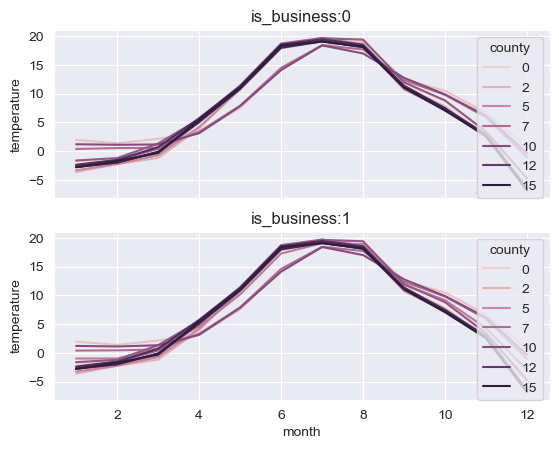

In [40]:
# 气温和地表温度与是否商业，月份，target的关系（因为气温和地表温度相似度极高，所以用温度替代）
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_is_consumption_month.loc[i], x='month', y='temperature',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

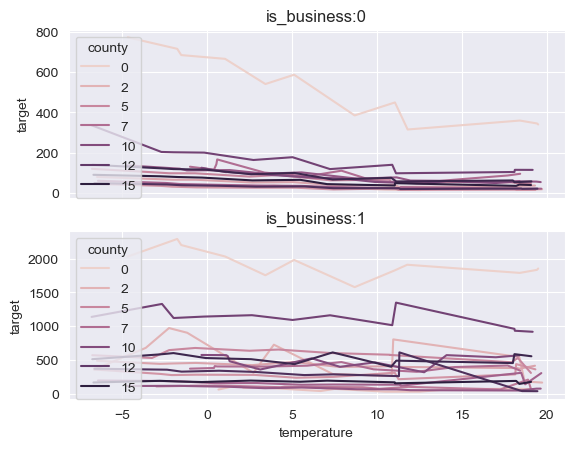

In [41]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_is_consumption_month.loc[i], x='temperature', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

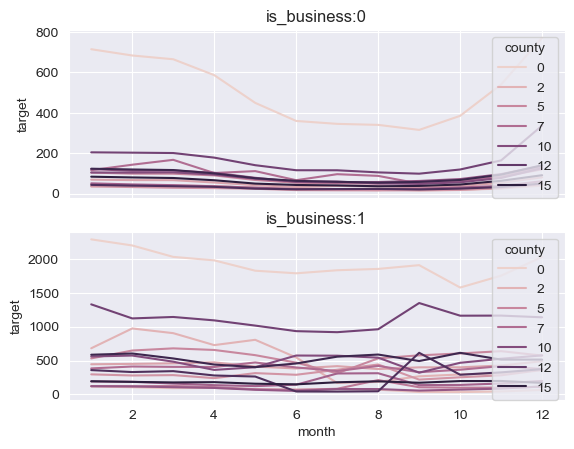

In [42]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_is_consumption_month.loc[i], x='month', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

In [43]:
merged_no_consumption_month  = merged_no_consumption.groupby(['is_business','month','county']).mean()
merged_no_consumption_month
merged_no_consumption_month_corr = merged_no_consumption_month[['target','temperature']]
merged_no_consumption_month_corr.corr()

,target,temperature
target,1.000000,0.155541
temperature,0.155541,1.000000


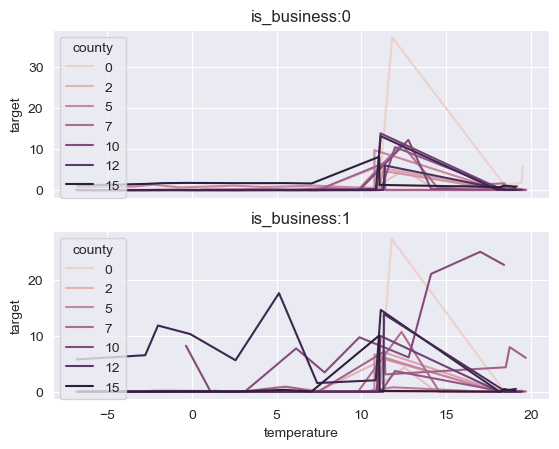

In [44]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_no_consumption_month.loc[i], x='temperature', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

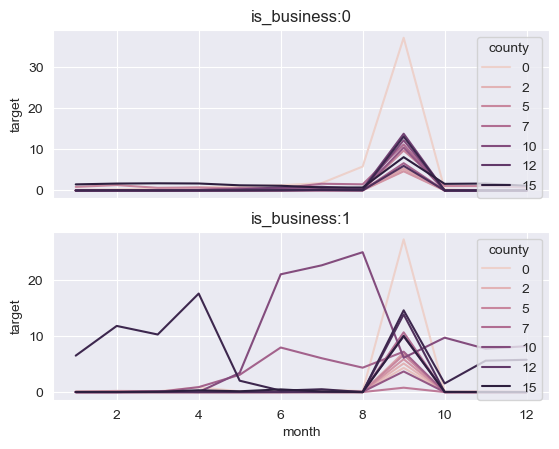

In [45]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_no_consumption_month.loc[i], x='month', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

由此可见生产目标和温度的相关性较大，消耗量与温度相关性较低，但消耗量为正相关

接下来测试降雨量,相似度极低,但不知道为什么生产量相似度依旧较高



In [46]:
merged_is_consumption_month_rain_corr = merged_is_consumption_month[['target','rain']]
merged_is_consumption_month_rain_corr.corr()

,target,rain
target,1.000000,-0.061205
rain,-0.061205,1.000000


In [47]:
merged_no_consumption_month_rain_corr = merged_no_consumption_month[['target','rain']]
merged_no_consumption_month_rain_corr.corr()

,target,rain
target,1.000000,0.011766
rain,0.011766,1.000000


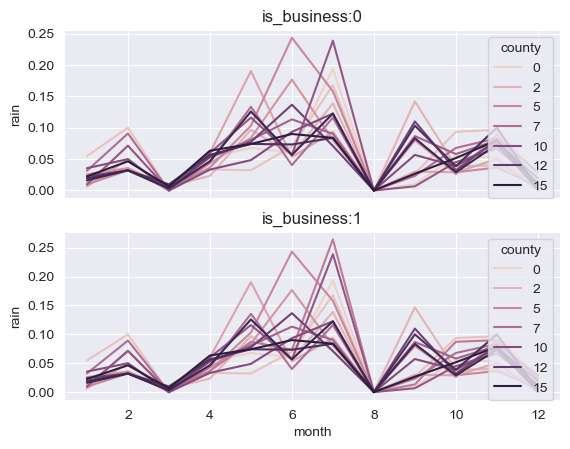

In [48]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_is_consumption_month_rain_corr.loc[i], x='month', y='rain',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

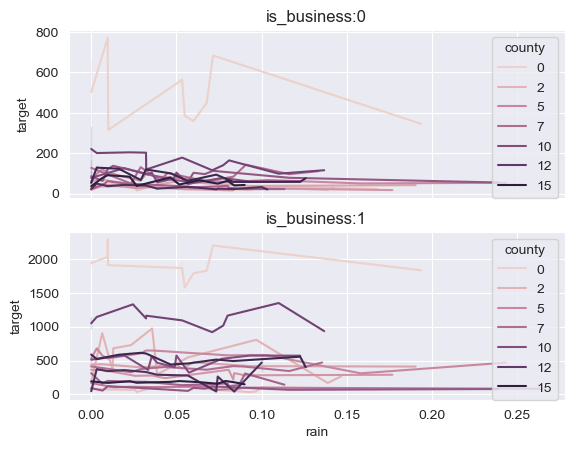

In [49]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_is_consumption_month_rain_corr.loc[i], x='rain', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

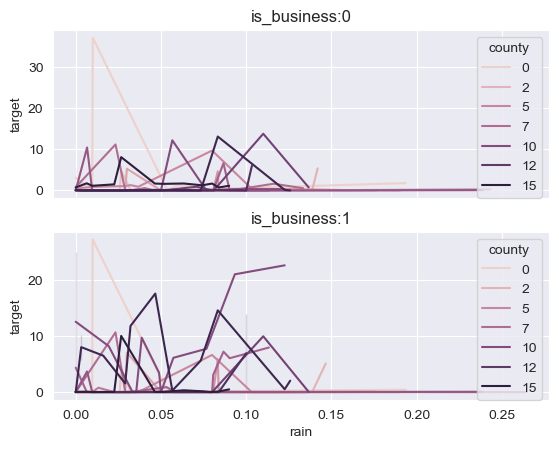

In [50]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_no_consumption_month_rain_corr.loc[i], x='rain', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

In [51]:
def xiangguan(index):
    return index+'生产的相关性为:{}'.format(merged_no_consumption_month[['target',index]].corr()),index+'消耗的相关性为:{}'.format(merged_is_consumption_month[['target',index]].corr())

In [52]:
xiangguan(index='snowfall')

('snowfall生产的相关性为:            target  snowfall\ntarget    1.000000 -0.141887\nsnowfall -0.141887  1.000000',
 'snowfall消耗的相关性为:            target  snowfall\ntarget    1.000000  0.051974\nsnowfall  0.051974  1.000000')

In [53]:
def picture_no_consumption(x,y):
    figure, axes = plt.subplots(2, 1, sharex=True)
    for i, ax in enumerate(axes.ravel()):
        sns.lineplot(data=merged_no_consumption_month.loc[i], x=x, y=y,hue='county',ax=ax)
        ax.set_title('is_business:'+str(i))
def picture_is_consumption(x,y):
    figure, axes = plt.subplots(2, 1, sharex=True)
    for i, ax in enumerate(axes.ravel()):
        sns.lineplot(data=merged_is_consumption_month.loc[i], x=x, y=y,hue='county',ax=ax)
        ax.set_title('is_business:'+str(i))

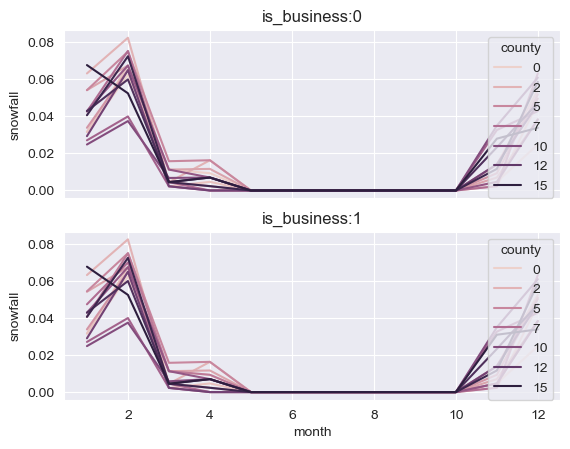

In [54]:
picture_no_consumption(x='month',y='snowfall')

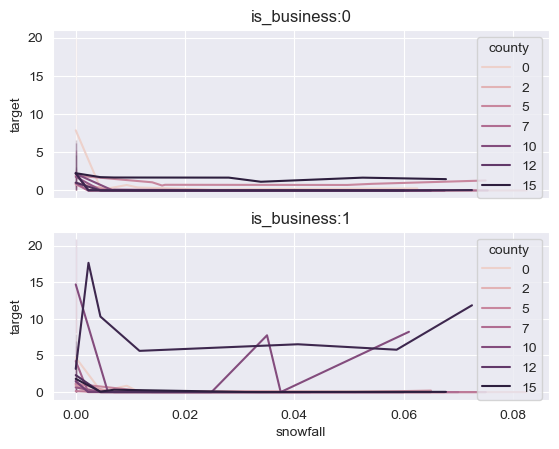

In [55]:
picture_no_consumption(x='snowfall',y='target')

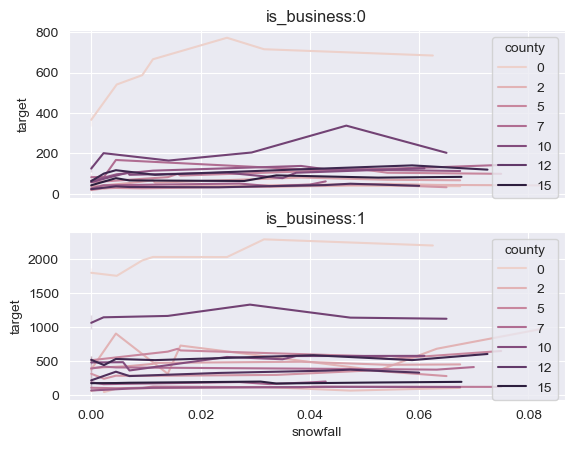

In [56]:
picture_is_consumption(x='snowfall',y='target')

In [57]:
indexs=['product_type','temperature','dewpoint','rain','snowfall','surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation']
for index in indexs:
    display(xiangguan(index))

('product_type生产的相关性为:                target  product_type\ntarget        1.000000      0.028002\nproduct_type  0.028002      1.000000',
 'product_type消耗的相关性为:                target  product_type\ntarget        1.000000     -0.344806\nproduct_type -0.344806      1.000000')

('temperature生产的相关性为:               target  temperature\ntarget       1.000000     0.155541\ntemperature  0.155541     1.000000',
 'temperature消耗的相关性为:              target  temperature\ntarget       1.00000     -0.08538\ntemperature -0.08538      1.00000')

('dewpoint生产的相关性为:          target  dewpoint\ntarget    1.0000    0.1986\ndewpoint  0.1986    1.0000',
 'dewpoint消耗的相关性为:            target  dewpoint\ntarget    1.000000 -0.088745\ndewpoint -0.088745  1.000000')

('rain生产的相关性为:          target      rain\ntarget  1.000000  0.011766\nrain    0.011766  1.000000',
 'rain消耗的相关性为:          target      rain\ntarget  1.000000 -0.061205\nrain   -0.061205  1.000000')

('snowfall生产的相关性为:            target  snowfall\ntarget    1.000000 -0.141887\nsnowfall -0.141887  1.000000',
 'snowfall消耗的相关性为:            target  snowfall\ntarget    1.000000  0.051974\nsnowfall  0.051974  1.000000')

('surface_pressure生产的相关性为:                    target  surface_pressure\ntarget            1.000000          0.103056\nsurface_pressure  0.103056          1.000000',
 'surface_pressure消耗的相关性为:                    target  surface_pressure\ntarget            1.000000         -0.091435\nsurface_pressure -0.091435          1.000000')

('cloudcover_total生产的相关性为:                    target  cloudcover_total\ntarget            1.000000          0.043456\ncloudcover_total  0.043456          1.000000',
 'cloudcover_total消耗的相关性为:                    target  cloudcover_total\ntarget            1.000000          0.034217\ncloudcover_total  0.034217          1.000000')

('cloudcover_low生产的相关性为:                  target  cloudcover_low\ntarget          1.000000        0.055395\ncloudcover_low  0.055395        1.000000',
 'cloudcover_low消耗的相关性为:                  target  cloudcover_low\ntarget          1.000000        0.041909\ncloudcover_low  0.041909        1.000000')

('cloudcover_mid生产的相关性为:                  target  cloudcover_mid\ntarget          1.000000       -0.191691\ncloudcover_mid -0.191691        1.000000',
 'cloudcover_mid消耗的相关性为:                  target  cloudcover_mid\ntarget          1.000000        0.040935\ncloudcover_mid  0.040935        1.000000')

('cloudcover_high生产的相关性为:                   target  cloudcover_high\ntarget           1.000000         0.026803\ncloudcover_high  0.026803         1.000000',
 'cloudcover_high消耗的相关性为:                   target  cloudcover_high\ntarget           1.000000        -0.024618\ncloudcover_high -0.024618         1.000000')

('windspeed_10m生产的相关性为:                 target  windspeed_10m\ntarget         1.000000       0.009264\nwindspeed_10m  0.009264       1.000000',
 'windspeed_10m消耗的相关性为:                 target  windspeed_10m\ntarget         1.000000      -0.077847\nwindspeed_10m -0.077847       1.000000')

('winddirection_10m生产的相关性为:                     target  winddirection_10m\ntarget             1.000000          -0.047167\nwinddirection_10m -0.047167           1.000000',
 'winddirection_10m消耗的相关性为:                     target  winddirection_10m\ntarget             1.000000           0.005288\nwinddirection_10m  0.005288           1.000000')

('shortwave_radiation生产的相关性为:                       target  shortwave_radiation\ntarget               1.000000             0.056575\nshortwave_radiation  0.056575             1.000000',
 'shortwave_radiation消耗的相关性为:                      target  shortwave_radiation\ntarget               1.00000             -0.06052\nshortwave_radiation -0.06052              1.00000')

('direct_solar_radiation生产的相关性为:                          target  direct_solar_radiation\ntarget                  1.000000                0.017639\ndirect_solar_radiation  0.017639                1.000000',
 'direct_solar_radiation消耗的相关性为:                          target  direct_solar_radiation\ntarget                  1.000000               -0.058994\ndirect_solar_radiation -0.058994                1.000000')

('diffuse_radiation生产的相关性为:                     target  diffuse_radiation\ntarget             1.000000           0.156812\ndiffuse_radiation  0.156812           1.000000',
 'diffuse_radiation消耗的相关性为:                     target  diffuse_radiation\ntarget             1.000000          -0.057311\ndiffuse_radiation -0.057311           1.000000')

In [58]:
merged_no_consumption_month.corr().loc['target']

data_block_id            -0.234038
target                    1.000000
is_consumption                 NaN
product_type              0.028002
hour                      0.590499
datetime                 -0.234014
temperature               0.155541
dewpoint                  0.198600
rain                      0.011766
snowfall                 -0.141887
surface_pressure          0.103056
cloudcover_total          0.043456
cloudcover_low            0.055395
cloudcover_mid           -0.191691
cloudcover_high           0.026803
windspeed_10m             0.009264
winddirection_10m        -0.047167
shortwave_radiation       0.056575
direct_solar_radiation    0.017639
diffuse_radiation         0.156812
latitude                 -0.122897
longitude                -0.059873
datetime_merge           -0.234014
year                     -0.228322
day                       0.001476
Name: target, dtype: float64

In [59]:
merged_is_consumption_month.corr().loc['target']

data_block_id            -0.023410
target                    1.000000
is_consumption                 NaN
product_type             -0.344806
hour                     -0.018849
datetime                 -0.023411
temperature              -0.085380
dewpoint                 -0.088745
rain                     -0.061205
snowfall                  0.051974
surface_pressure         -0.091435
cloudcover_total          0.034217
cloudcover_low            0.041909
cloudcover_mid            0.040935
cloudcover_high          -0.024618
windspeed_10m            -0.077847
winddirection_10m         0.005288
shortwave_radiation      -0.060520
direct_solar_radiation   -0.058994
diffuse_radiation        -0.057311
latitude                  0.199631
longitude                -0.022823
datetime_merge           -0.023411
year                      0.011820
day                       0.020115
Name: target, dtype: float64

## 由以上两个相关性可知：
### 与生产相关性高的有时间，温度，降雪，云层覆盖度，太阳辐射，较高的有降雨，地表压强，风速；
### 与消耗相关性较高的有产品类型；

# 预测天气部分